In [1]:
!pip install qiskit==1.1
!pip install qiskit_aer
!pip install pylatexenc

In [2]:
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer

import matplotlib
import numpy as np

In [3]:
def prepare_state_register(qc, assign, anc_const, flag_state, flag_limit, anc_cost, cost, superflag):
    qc.reset(assign)
    qc.reset(anc_const)
    qc.reset(flag_state)
    qc.reset(flag_limit)
    qc.reset(anc_cost)
    qc.reset(cost)
    qc.reset(superflag)
    qc.h(assign)
    qc.x(cost)
    qc.x(superflag)
    qc.h(superflag)
    qc.barrier()

In [4]:
def oracle_objective_phase(qc, assign, anc_cost, cost, cost_matrix, alpha = 1.0):
    # Encode the weight matrix into controlled phase rotations using θ = arccos(sqrt(w_norm)) (Fig. 2 Oracle – Objective).
    qc.barrier()

    # max_w = float(np.max(cost_matrix))
    max_w = 1
    N, M = cost_matrix.shape

    for i in range(N):
        pair = [assign[2*i], assign[2*i+1]]

        for j in range(M):
            w = cost_matrix[i, j]
            w_norm = w / max_w
            theta = np.arccos(np.sqrt(1 - w_norm))
            mask  = format(j, '02b')

            qc.barrier()

            for b, bit in enumerate(reversed(mask)):
                if bit == '0':
                    qc.x(pair[b])

            qc.mcx(pair,anc_cost) # for [log2n] == 2
            qc.cry(theta, anc_cost, cost[i])
            qc.mcx(pair,anc_cost)

            for b, bit in enumerate(reversed(mask)):
                if bit == '0':
                    qc.x(pair[b])

            qc.barrier()

    qc.barrier()

In [5]:
def inverse_oracle_objective_phase(qc, assign, anc_cost, cost, cost_matrix, alpha = 1.0):
    # Encode the weight matrix into controlled phase rotations using θ = arccos(sqrt(w_norm)) (Fig. 2 Oracle – Objective).
    qc.barrier()

    # max_w = float(np.max(cost_matrix))
    max_w = 1
    N, M = cost_matrix.shape

    for i in reversed(range(N)):
        pair = [assign[2*i], assign[2*i+1]]

        for j in reversed(range(M)):
            w = cost_matrix[i, j]
            w_norm = w / max_w
            theta = np.arccos(np.sqrt(1 - w_norm))
            mask  = format(j, '02b')

            qc.barrier()

            for b, bit in enumerate(reversed(mask)):
                if bit == '0':
                    qc.x(pair[b])

            qc.mcx(pair,anc_cost) # for [log2n] == 2
            qc.cry(-theta, anc_cost, cost[i])
            qc.mcx(pair,anc_cost)

            for b, bit in enumerate(reversed(mask)):
                if bit == '0':
                    qc.x(pair[b])

            qc.barrier()

    qc.barrier()

In [6]:
def oracle_state_violation(qc, assign, anc_const, flag_state):
  # for 11 violation -> when N=3
  qc.barrier()
  qc.mcx([assign[0], assign[1]], anc_const[0])
  qc.mcx([assign[2], assign[3]], anc_const[1])
  qc.mcx([assign[4], assign[5]], anc_const[2])
  qc.x(anc_const)
  qc.mcx(anc_const, flag_state)
  qc.x(anc_const)
  qc.mcx([assign[4], assign[5]], anc_const[2])
  qc.mcx([assign[2], assign[3]], anc_const[1])
  qc.mcx([assign[0], assign[1]], anc_const[0])
  qc.barrier()

In [7]:
def inverse_oracle_state_violation(qc, assign, anc_const, flag_state):
  # for 11 violation -> when N=3
  qc.barrier()
  qc.mcx([assign[0], assign[1]], anc_const[0])
  qc.mcx([assign[2], assign[3]], anc_const[1])
  qc.mcx([assign[4], assign[5]], anc_const[2])
  qc.x(anc_const)
  qc.mcx(anc_const, flag_state)
  qc.x(anc_const)
  qc.mcx([assign[4], assign[5]], anc_const[2])
  qc.mcx([assign[2], assign[3]], anc_const[1])
  qc.mcx([assign[0], assign[1]], anc_const[0])
  qc.barrier()

In [8]:
def compare_nodes(
        qc,
        assign,
        node_a: int,
        node_b: int,
        out_qubit: int,
        ancilla_qubits,
    ):
    qc.barrier()

    a0, a1 = 2*(node_a-1), 2*(node_a-1)+1   # node_a LSB/MSB
    b0, b1 = 2*(node_b-1), 2*(node_b-1)+1   # node_b LSB/MSB
    anc0, anc1, anc2 = ancilla_qubits

    qc.cx(assign[a0], assign[b0])
    qc.cx(assign[a1], assign[b1])

    qc.cx(assign[b0], anc0)
    qc.cx(assign[b1], anc1)

    qc.x([anc0, anc1])
    qc.mcx([anc0, anc1], out_qubit)
    qc.x([anc0, anc1])

    qc.cx(assign[b1], anc1)
    qc.cx(assign[b0], anc0)

    qc.cx(assign[a1], assign[b1])
    qc.cx(assign[a0], assign[b0])

    qc.barrier()

In [9]:
def oracle_resource_block_limit(qc, assign, anc_const, flag_limit):
  # for 01, 12, 20 block_limit -> when N=3
  pattern = [(1,2), (2,3), (3,1)]

  qc.barrier()
  compare_nodes(qc, assign, 1, 2, flag_limit[0], anc_const)
  compare_nodes(qc, assign, 2, 3, flag_limit[1], anc_const)
  compare_nodes(qc, assign, 1, 3, flag_limit[2], anc_const)
  qc.barrier()

In [10]:
def inverse_oracle_resource_block_limit(qc, assign, anc_const, flag_limit):
  # for 01, 12, 20 block_limit -> when N=3
  pattern = [(1,2), (2,3), (3,1)]

  qc.barrier()
  compare_nodes(qc, assign, 1, 3, flag_limit[2], anc_const)
  compare_nodes(qc, assign, 2, 3, flag_limit[1], anc_const)
  compare_nodes(qc, assign, 1, 2, flag_limit[0], anc_const)
  qc.barrier()

In [11]:
def apply_superflag(qc, assign, flag_state, flag_limit, cost, superflag):
    qc.barrier()

    control_qubits=list(flag_state) + list(flag_limit) + list(cost)

    qc.x(flag_limit)
    qc.mcx(control_qubits, superflag)
    qc.x(flag_limit)

    qc.h(superflag)

    qc.barrier()

In [12]:
def apply_oracle(
    qc,
    assign,
    anc_const,
    flag_state,
    flag_limit,
    anc_cost,
    cost,
    superflag,
    cost_matrix,
    alpha
):
    oracle_objective_phase(qc, assign, anc_cost, cost, cost_matrix, alpha)

    oracle_state_violation(qc, assign, anc_const, flag_state)
    oracle_resource_block_limit(qc, assign, anc_const, flag_limit)

    apply_superflag(qc, assign, flag_state, flag_limit, cost, superflag)

    inverse_oracle_resource_block_limit(qc, assign, anc_const, flag_limit)
    inverse_oracle_state_violation(qc, assign, anc_const, flag_state)

    inverse_oracle_objective_phase(qc, assign, anc_cost, cost, cost_matrix, alpha)


In [13]:
def apply_diffusion(qc, assign):
    # Diffusion operator about the uniform superposition (core of amplitude‑amplification).
    qc.h(assign)
    qc.x(assign)
    qc.h(assign[-1])
    qc.mcx(assign[:-1], assign[-1])
    qc.h(assign[-1])
    qc.x(assign)
    qc.h(assign)
    qc.barrier()

In [14]:
def amplify_amplitude(
    # Repeatedly apply oracle ⊕ diffusion to amplify the amplitude of feasible low‑power states (Fig. 2 Diffusion + Amplification).
    N_MATCH,
    cost_matrix,
    alpha=1.0, iterations=1
):
    N = N_MATCH
    N_STATE = N * np.ceil(np.log2(N)).astype(int)
    N_VIO = int(N * (N - 1) / 2)

    assign    = QuantumRegister(N_STATE,  name='q_assign')
    anc_const = QuantumRegister(N,        name='q_anc_const')
    flag_state = QuantumRegister(1,        name='q_flag_stae')
    flag_limit = QuantumRegister(N_VIO,    name='q_flag_access')
    anc_cost  = QuantumRegister(1,        name='q_anc_cost')
    cost      = QuantumRegister(N, name="q_cost")
    superflag = QuantumRegister(1,        name='q_super')
    cl        = ClassicalRegister(N_STATE, name='c')

    qc = QuantumCircuit(assign, anc_const, flag_state, flag_limit, anc_cost, cost, superflag, cl,
                    name='GroverWithSuperflag')

    prepare_state_register(qc, assign, anc_const, flag_state, flag_limit, anc_cost, cost, superflag)

    for _ in range(iterations):
        apply_oracle(
            qc,
            assign,
            anc_const,
            flag_state,
            flag_limit,
            anc_cost,
            cost,
            superflag,
            cost_matrix,
            alpha
        )
        apply_diffusion(qc, assign)

    qc.barrier()
    qc.measure(assign, cl)
    return qc

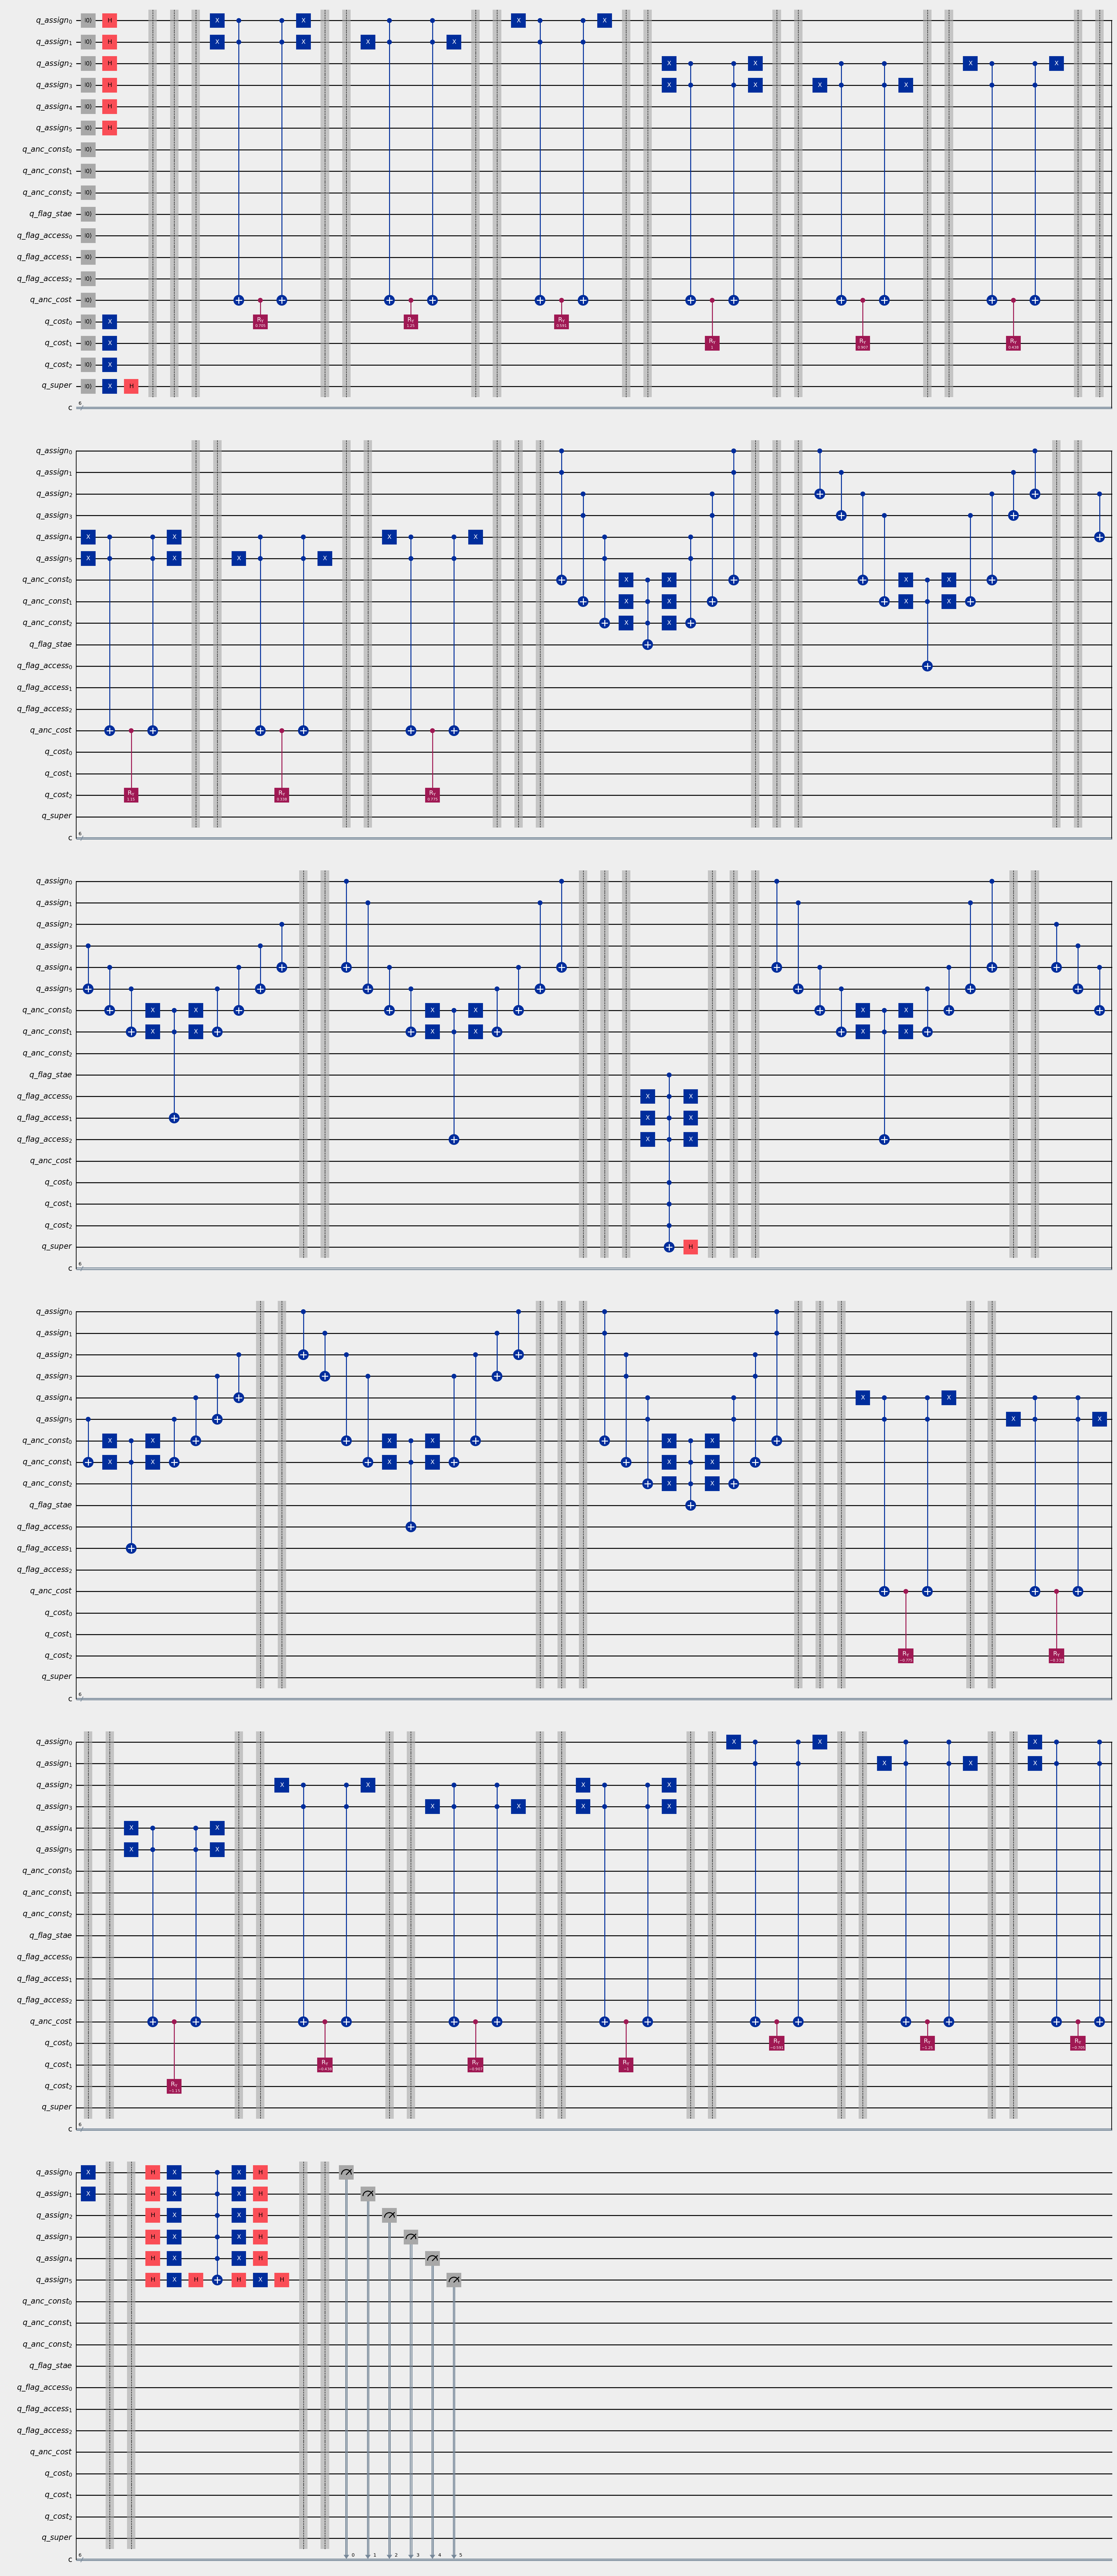

In [15]:
N_MATCH = 3;
# cost_matrix = np.array([[0.68472,  1.24900,  0.57964],
#                  [0.99116,  0.88608,  0.46365],
#                  [1.10710,  0.32175,  0.78540]])

cost_matrix = np.array([[0.42,  0.90,  0.31],
                 [0.71,  0.62,  0.18],
                 [0.83,  0.11,  0.49]])

qc = amplify_amplitude(N_MATCH, cost_matrix, alpha=0.5, iterations=1)

qc.draw(output='mpl',
        scale=1.0,
        fold=48,
        style={'backgroundcolor':'#EEEEEE'},
        plot_barriers=True)

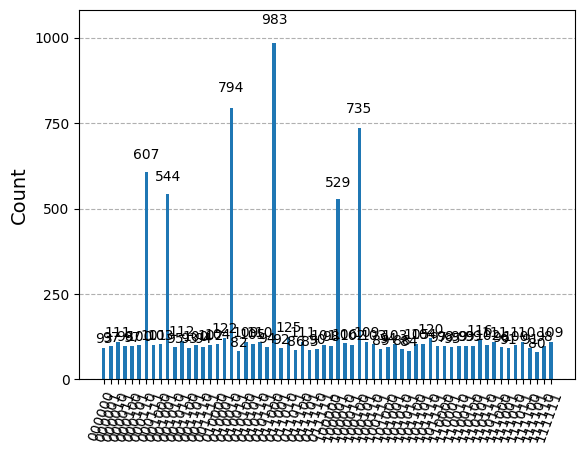

In [16]:
backend = Aer.get_backend('aer_simulator')
transpiled = transpile(qc, backend)
result = backend.run(transpiled, shots=10000).result()
counts = result.get_counts()
hist = plot_histogram(counts)
hist